## **Modelos Machine Learning**

Datasets: "**Previsão de sobrevivência dos passageiros do Titanic e Segmentação de clientes para análise comportamental**"



**Aluna:** Gabriela Rodrigues de Almeida


> Santander Coders 2024.1

> Turma #1175 - Data Science

> Professor Rogério Mainardes - Machine Learning II



## Imports das Bibliotecas:

In [1]:
# Bibliotecas padrão
import os
import zipfile
import requests

# Bibliotecas para manipulação de dados
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Bibliotecas para modelagem e pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.cluster import KMeans

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



# **Modelo Supervisionado**

## Sobre o Dataset

---




**1. Previsão de sobrevivência dos passageiros (Titanic Dataset)**
* **Fonte:** Titanic: Machine Learning from Disaster (Stanford University)
* **Descrição:** Este dataset contém informações sobre os passageiros do RMS Titanic, como idade, classe, sexo, número de irmãos/cônjuges a bordo, entre outras. A variável alvo é a sobrevivência do passageiro, que será prevista com base nas características fornecidas.


In [2]:
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
data = pd.read_csv(url)

print(f'Há {data.shape[0]} linhas e {data.shape[1]} colunas.\n\n')

print('As primeiras linhas do dataset podem ser vistas abaixo: ')
data.head()

Há 887 linhas e 8 colunas.


As primeiras linhas do dataset podem ser vistas abaixo: 


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Análise Exploratória dos Dados
---

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


Com df.info() é possível perceber algumas coisas:

• As variáveis são quase todas numéricas e inteiras, com exceção das colunas de Name e Sex.

• Além disso, não há valores nulos.

In [4]:
data.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [5]:
data.isnull().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
Siblings/Spouses Aboard,0
Parents/Children Aboard,0
Fare,0


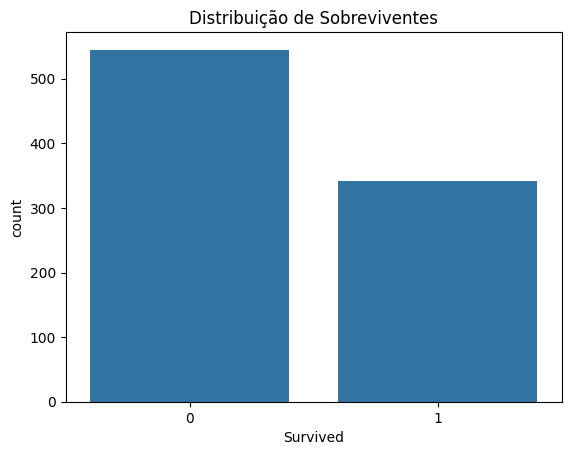

In [6]:
# Distribuição da variável alvo: Sobrevivência
sns.countplot(x='Survived', data=data)
plt.title('Distribuição de Sobreviventes')
plt.show()

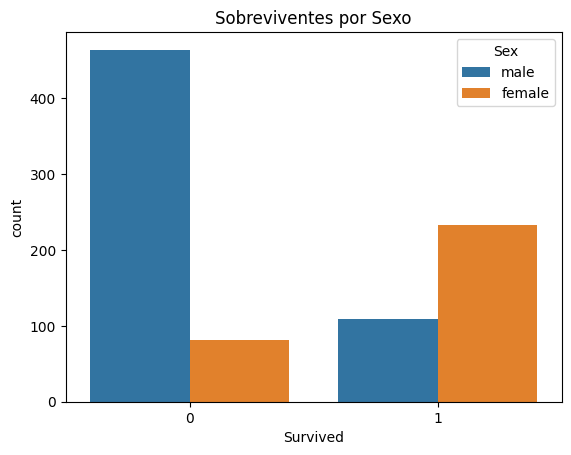

In [7]:
# Distribuição por Sexo
sns.countplot(x='Survived', hue='Sex', data=data)
plt.title('Sobreviventes por Sexo')
plt.show()


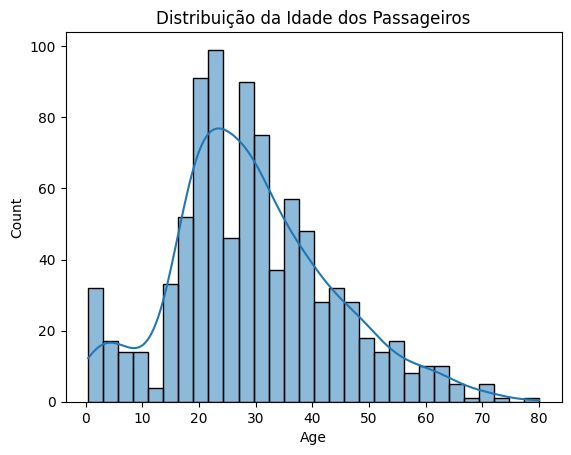

In [8]:
# Distribuição de idades
sns.histplot(data['Age'], kde=True, bins=30)
plt.title('Distribuição da Idade dos Passageiros')
plt.show()


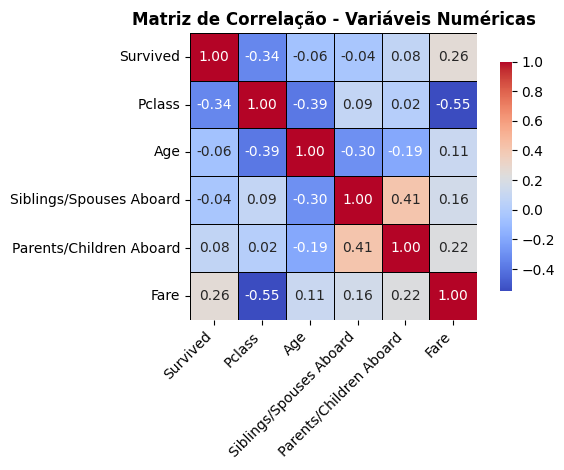

In [9]:
# Correlação das Variáveis Numéricas
numeric_data = data.select_dtypes(include=[np.number])

corr_matrix = numeric_data.corr()
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={"shrink":.8}, linewidths=.5, linecolor='black')
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


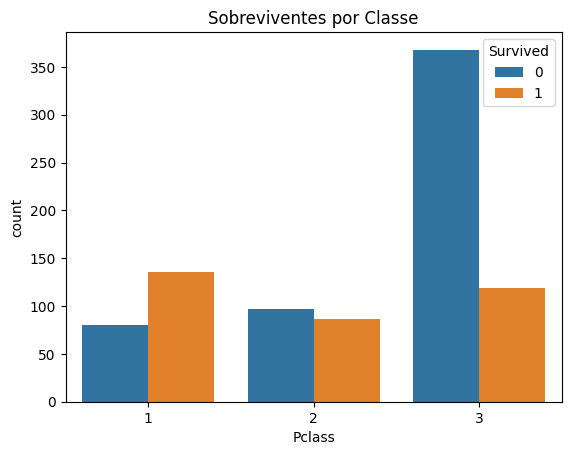

In [10]:
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Sobreviventes por Classe')
plt.show()


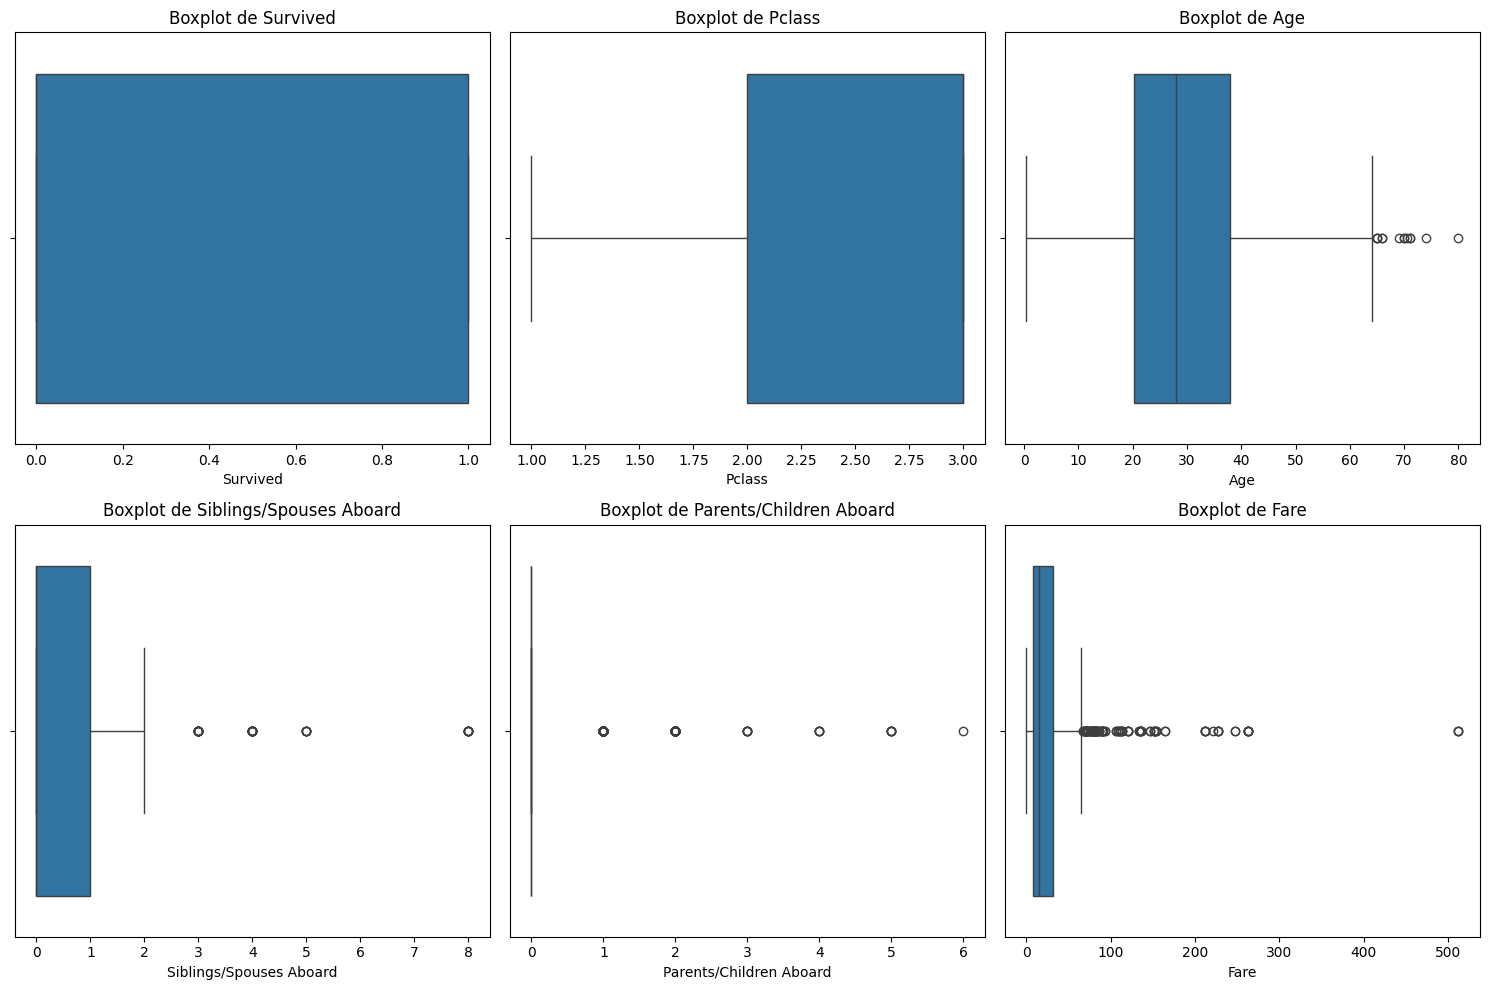

In [11]:
n_cols = 3  # Número de colunas por linha
n_rows = (len(numeric_data.columns) // n_cols) + int(len(numeric_data.columns) % n_cols > 0)  # Número de linhas necessário


plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(numeric_data):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot de {feature}')

plt.tight_layout()
plt.show()

z_scores = np.abs(zscore(numeric_data))


outliers = (z_scores > 3)



## Pré-processamento

In [12]:
data = data.drop(['Name'], axis=1)

In [13]:
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)

In [14]:
data.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_male
0,0,3,22.0,1,0,7.2500,True
1,1,1,38.0,1,0,71.2833,False
2,1,3,26.0,0,0,7.9250,False
3,1,1,35.0,1,0,53.1000,False
4,0,3,35.0,0,0,8.0500,True


## Divisão de Treino e Teste

In [15]:
X = data.drop('Survived', axis=1)
y = data['Survived']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


## Treinamento de Modelos

### Modelo Supervisionado - Random Forest (Ensemble)

In [17]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(f"Acurácia do modelo de Random Forest: {accuracy_score(y_test, y_pred_rf):.2f}")

Acurácia do modelo de Random Forest: 0.78


In [18]:
y_pred_rf = rf_model.predict(X_test)


print("Avaliação do modelo Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print("Relatório de Classificação:")

print(classification_report(y_test, y_pred_rf))

Avaliação do modelo Random Forest:
Acurácia: 0.78
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       111
           1       0.70      0.70      0.70        67

    accuracy                           0.78       178
   macro avg       0.76      0.76      0.76       178
weighted avg       0.78      0.78      0.78       178



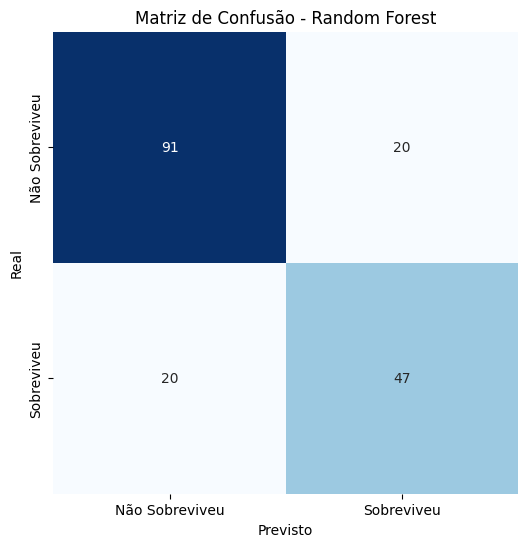

In [19]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

### Modelo Supervisionado - SVM

In [20]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print(f"Acurácia do modelo SVM: {accuracy_score(y_test, y_pred_svm):.2f}")

Acurácia do modelo SVM: 0.65


In [21]:
y_pred_svm = svm_model.predict(X_test)

print("\nAvaliação do modelo SVM:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_svm):.2f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_svm))


Avaliação do modelo SVM:
Acurácia: 0.65
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       111
           1       0.67      0.15      0.24        67

    accuracy                           0.65       178
   macro avg       0.66      0.55      0.51       178
weighted avg       0.66      0.65      0.57       178



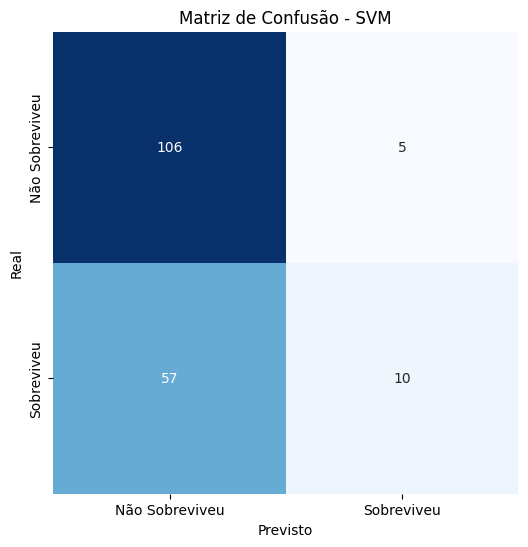

In [22]:
cm_svm = confusion_matrix(y_test, y_pred_svm)


plt.figure(figsize=(6, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title("Matriz de Confusão - SVM")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

A análise dos dois modelos (Random Forest e SVM) para a previsão de sobrevivência no Titanic mostrou resultados distintos em termos de desempenho.

O modelo **Random Forest** demonstrou uma performance equilibrada entre as classes "Sobreviveu" e "Não Sobreviveu". Com uma acurácia de 78%, o modelo teve um bom desempenho geral, com uma precisão de 82% na classe "Não Sobreviveu" e 70% na classe "Sobreviveu". O modelo conseguiu prever com boa precisão a classe majoritária (não sobreviveu), mas teve um desempenho ligeiramente inferior ao tentar prever a classe minoritária (sobreviveu).

O modelo **SVM** apresentou uma performance inferior em comparação com o Random Forest, com uma acurácia de 65%. A precisão na classe "Não Sobreviveu" foi de 65%, enquanto na classe "Sobreviveu" foi de 67%. No entanto, o modelo SVM teve um recall muito baixo para a classe "Sobreviveu" (0.15), o que significa que ele não foi eficiente em identificar os passageiros que sobreviveram.

# **Modelo Não Supervisionado**

## Sobre o Dataset

---





**2.Segmentação de clientes para análise comportamental (UCI)**

* **Fonte:** Online Retail II Data Set
* **Descrição:** Dados sobre transações de compras online. Esse dataset será utilizado para criar um modelo de clusterização (e.g., RFM ou KMeans) e entender padrões de comportamento dos consumidores.

In [23]:
url2 = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"

zip_path = "online_retail_ii.zip"


response = requests.get(url2)
with open(zip_path, "wb") as file:
    file.write(response.content)

print("Arquivo ZIP baixado com sucesso!")


extract_folder = "online_retail_data"


if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


extracted_files = os.listdir(extract_folder)
print("Arquivos extraídos:", extracted_files)

Arquivo ZIP baixado com sucesso!
Arquivos extraídos: ['online_retail_II.xlsx']


In [24]:
xlsx_path = os.path.join(extract_folder, "online_retail_II.xlsx")

retail = pd.read_excel(xlsx_path)

df = pd.DataFrame(retail)


In [25]:
print(f'Há {df.shape[0]} linhas e {df.shape[1]} colunas.\n')
print('As primeiras linhas do dataset podem ser vistas abaixo: ')
df.head()

Há 525461 linhas e 8 colunas.

As primeiras linhas do dataset podem ser vistas abaixo: 


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Análise Exploratória dos Dados
---

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [27]:
df.dropna(subset=['Customer ID', 'Description'], inplace=True)
df.drop_duplicates(inplace=True)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410763 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      410763 non-null  object        
 1   StockCode    410763 non-null  object        
 2   Description  410763 non-null  object        
 3   Quantity     410763 non-null  int64         
 4   InvoiceDate  410763 non-null  datetime64[ns]
 5   Price        410763 non-null  float64       
 6   Customer ID  410763 non-null  float64       
 7   Country      410763 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.2+ MB


In [29]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [30]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,410763.000000,410763,410763.000000,410763.000000,410763.000000
mean,12.923735,2010-06-30 19:56:14.853674752,3.908358,15353.621857,20.242465
min,-9360.000000,2009-12-01 07:45:00,0.000000,12346.000000,-25111.090000
25%,2.000000,2010-03-26 09:46:00,1.250000,13979.000000,4.500000
50%,5.000000,2010-07-08 15:09:00,1.950000,15311.000000,11.800000
75%,12.000000,2010-10-14 12:32:00,3.750000,16797.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000,15818.400000
std,102.039550,NaN,71.714794,1681.657665,100.710825


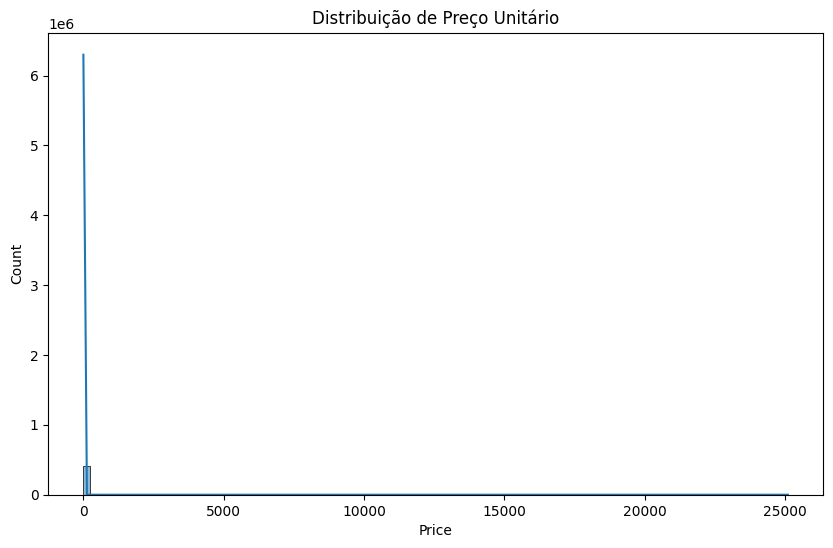

In [31]:
# Distribuição de preços unitários
plt.figure(figsize=(10,6))
sns.histplot(df['Price'], bins=100, kde=True)
plt.title('Distribuição de Preço Unitário')
plt.show()


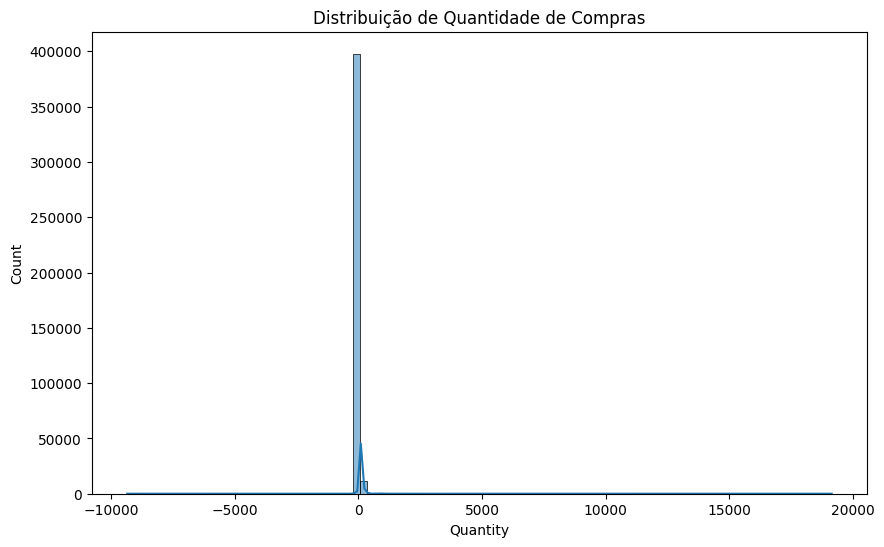

In [32]:
# Distribuição das quantidades de compras
plt.figure(figsize=(10,6))
sns.histplot(df['Quantity'], bins=100, kde=True)
plt.title('Distribuição de Quantidade de Compras')
plt.show()

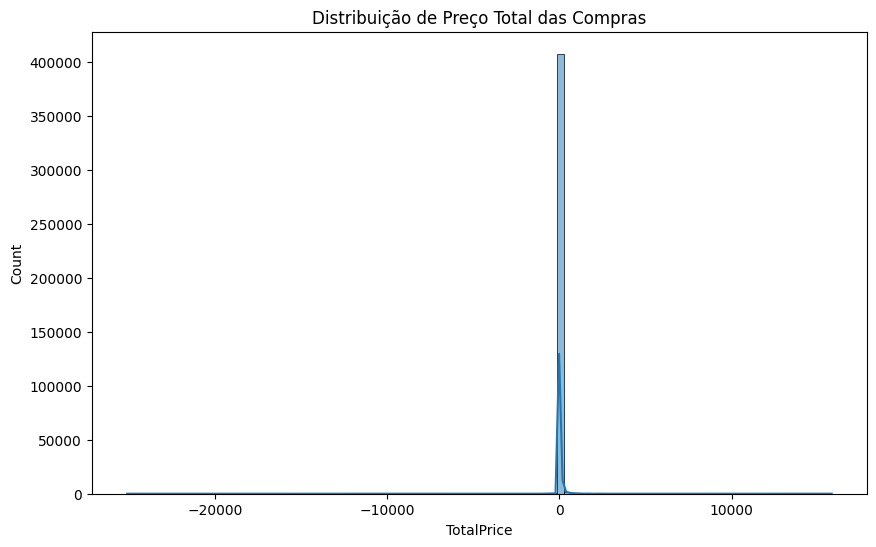

In [33]:
# Distribuição de TotalPrice
plt.figure(figsize=(10,6))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.title('Distribuição de Preço Total das Compras')
plt.show()

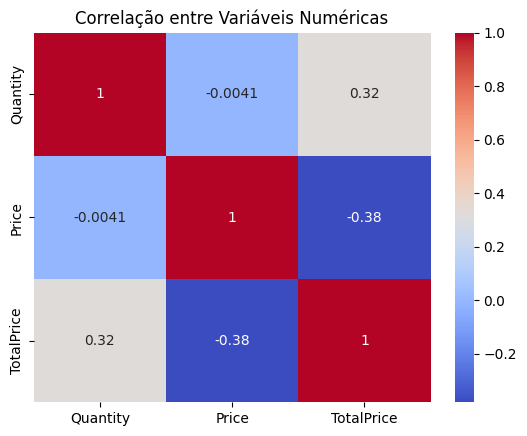

In [34]:
# Correlações entre variáveis numéricas
corr_matrix = df[['Quantity', 'Price', 'TotalPrice']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis Numéricas')
plt.show()


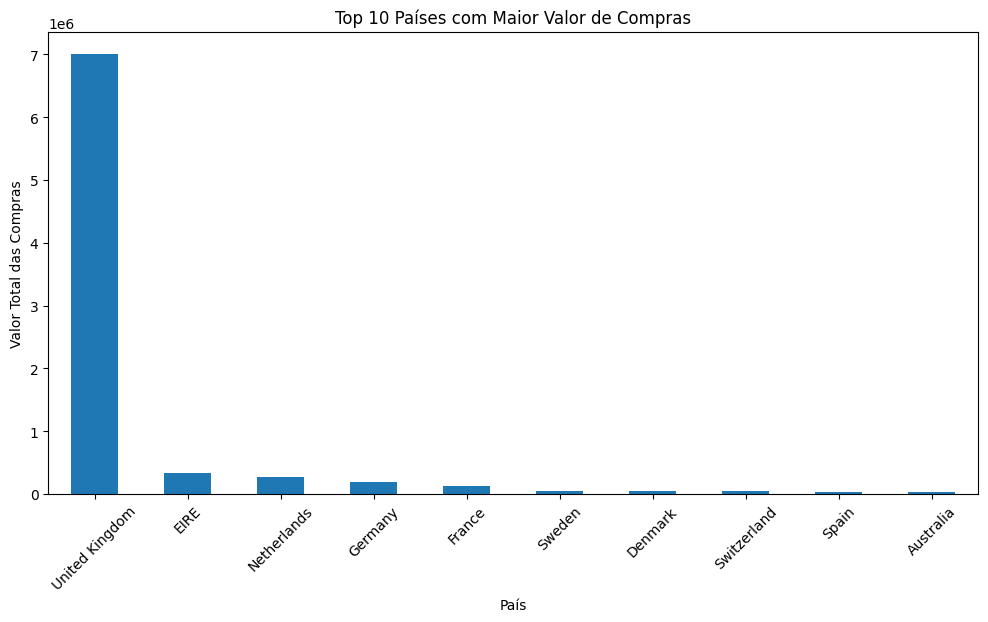

In [35]:
# Valores totais por país
country_group = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
country_group.plot(kind='bar')
plt.title('Top 10 Países com Maior Valor de Compras')
plt.xlabel('País')
plt.ylabel('Valor Total das Compras')
plt.xticks(rotation=45)
plt.show()

## KMeans

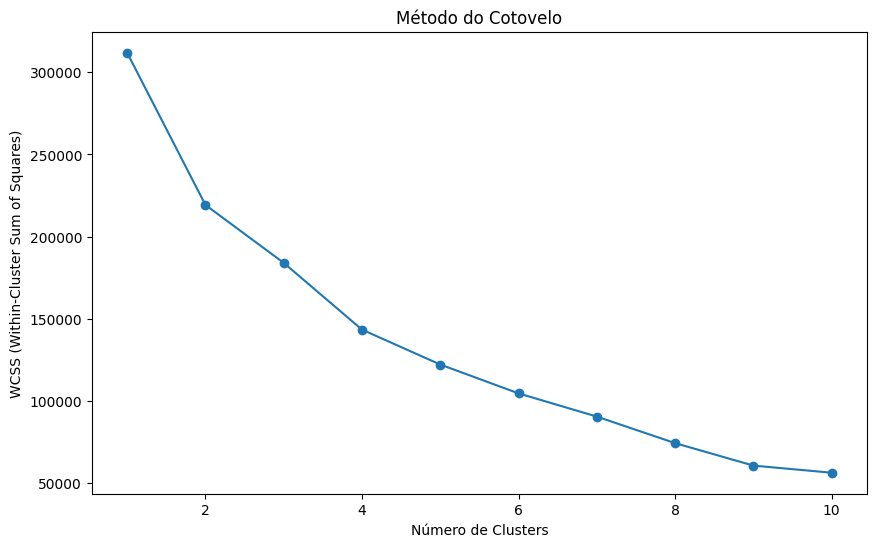

In [37]:
# Método do Cotovelo
df_cluster = df[['Customer ID', 'Quantity', 'TotalPrice']].drop_duplicates()


scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster[['Quantity', 'TotalPrice']])

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plotando o gráfico da Regra do Cotovelo
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


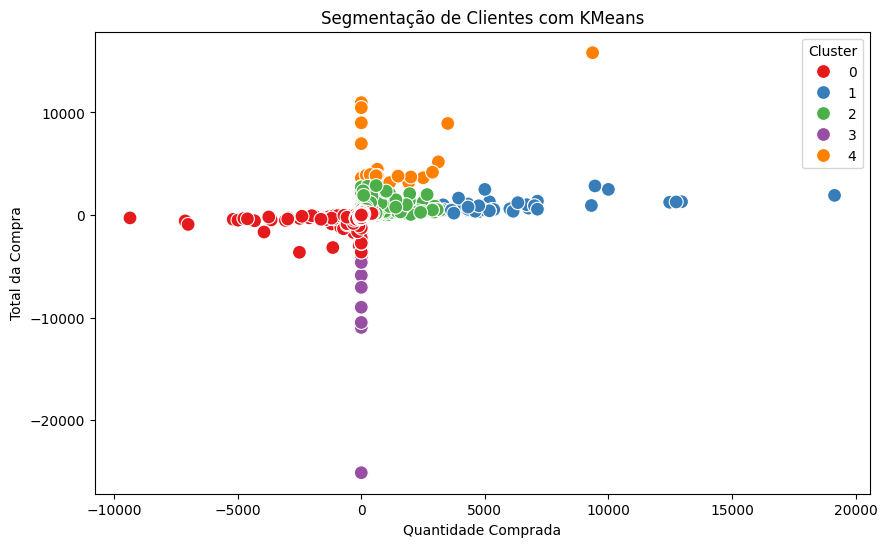

In [38]:
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_cluster_scaled)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_cluster['Quantity'], y=df_cluster['TotalPrice'], hue=df_cluster['Cluster'], palette='Set1', s=100)
plt.title('Segmentação de Clientes com KMeans')
plt.xlabel('Quantidade Comprada')
plt.ylabel('Total da Compra')
plt.legend(title='Cluster')
plt.show()

In [39]:
print('Centros dos Clusters:')
print(kmeans.cluster_centers_)


Centros dos Clusters:
[[-3.47759888e-02 -3.22253679e-02]
 [ 4.03216295e+01  5.83177796e+00]
 [ 3.22712672e+00  4.57066142e+00]
 [-1.15091031e-01 -6.37876050e+01]
 [ 9.49914935e+00  3.79134464e+01]]


In [40]:
print(df_cluster.groupby('Cluster').agg({'Quantity': ['mean', 'std'], 'TotalPrice': ['mean', 'std']}))

            Quantity                TotalPrice             
                mean          std         mean          std
Cluster                                                    
0          10.876029    59.702918    19.956401    54.074009
1        5973.600000  3030.220791   864.827200   596.925969
2         493.810700   522.079407   685.004866   464.104072
3          -1.000000     0.000000 -9165.872000  5985.357526
4        1419.521739  2042.400100  5487.125652  3315.357725


## RFM

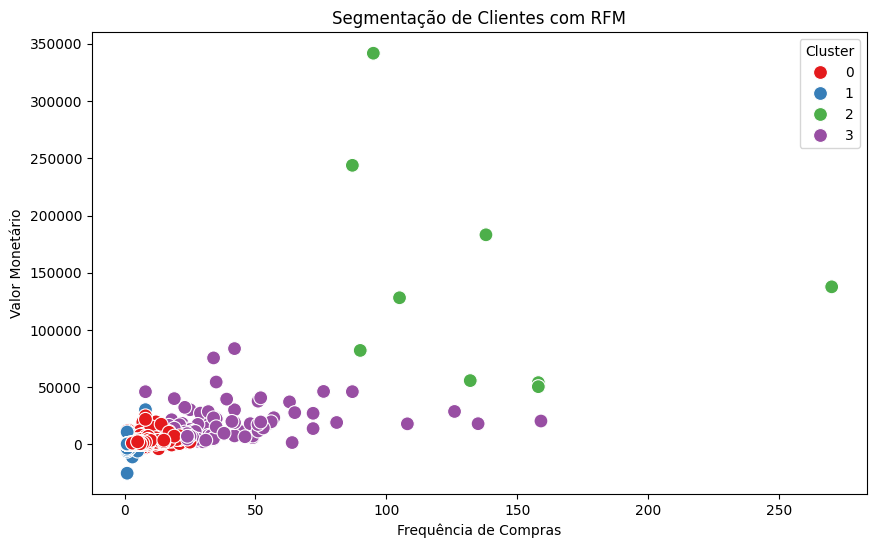

In [48]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
now = df['InvoiceDate'].max() + pd.Timedelta(days=1)


df['Recency'] = (now - df['InvoiceDate']).dt.days


rfm = df.groupby('Customer ID').agg({
    'Recency': 'min',
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={'Invoice': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

kmeans_rfm = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans_rfm.fit_predict(rfm_scaled)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Frequency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='Set1', s=100)
plt.title('Segmentação de Clientes com RFM')
plt.xlabel('Frequência de Compras')
plt.ylabel('Valor Monetário')
plt.legend(title='Cluster')
plt.show()


A análise das distribuições de Quantity, UnitPrice, e TotalPrice revelou insights importantes sobre o comportamento de compras dos clientes. Verificou-se que muitas transações são caracterizadas por pequenas quantidades e valores baixos, um padrão comum em datasets de varejo.

As correlações entre as variáveis numéricas, especialmente entre Quantity e TotalPrice, foram significativas e alinhadas às expectativas, mostrando que a quantidade adquirida tem uma relação direta com o valor total da compra.

***Método do Cotovelo***

A aplicação do Método do Cotovelo foi crucial para determinar o número ideal de clusters para o modelo KMeans. A análise do gráfico mostrou que cinco clusters são ideais, equilibrando a redução do WCSS com a simplicidade do modelo. Essa escolha permitiu uma segmentação mais eficiente e significativa, destacando grupos de clientes com comportamentos distintos.

***Segmentação por RFM***

A segmentação baseada no modelo RFM (Recência, Frequência e Valor Monetário) trouxe uma dimensão comportamental rica para a análise. Com o RFM, foi possível identificar grupos de clientes com base no tempo desde a última compra, frequência de compras e valor total gasto.

***Conclusão***

A combinação do Método do Cotovelo com o KMeans e a análise por RFM proporcionou uma visão robusta do comportamento de compra. Enquanto o KMeans segmentou clientes com base em padrões quantitativos gerais, o RFM ofereceu insights detalhados sobre hábitos de consumo. Juntas, essas abordagens permitem:

* Desenvolver campanhas de marketing direcionadas e mais eficazes.
* Personalizar ofertas e melhorar a experiência do cliente.
* Identificar oportunidades de aumento de receita com clientes recorrentes ou de alto valor.

